# Expectation-Maximization Algorithm

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

def normal_1d(x, mu, variance):
    '''1D Normal distribution with average 'mu' and variance given by variable 'variance'.
       Variable 'x' can be a numpy array of values, in which case the fucntion returns
       an array.'''
    
    sigma = np.sqrt(variance)
    gauss = np.exp(-(x - mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
    
    return gauss

## Expectation Step

We need to calculate

\begin{equation}
\gamma_{nk} = \frac{\pi_k \mathcal{N}({\bf x}_n|{\boldsymbol \mu}_k,\Sigma_k)}{\sum_{j=1}^{K}\pi_j\mathcal{N}({\bf x}_n|{\boldsymbol \mu}_j,\Sigma_j)}
\end{equation}

Since we are working with 1D Normal distributions, we can just calculate:

\begin{equation}
\gamma_{nk} = \frac{\pi_k \mathcal{N}({x}_n|{\mu}_k,\sigma_k)}{\sum_{j=1}^{K}\pi_j\mathcal{N}({x}_n|{\mu}_j,\sigma_j)}
\end{equation}

Note that the former equation has bold symbols (vectors) while the latter uses only scalar variables.

In [14]:
def expectation(data, averages, variances, weights):
    '''Expectation step. 'data' is a numpy array of values to be adjusted, 'averages' and 
       'variances' numpy arrays containing the averages and variances of the Normal distributions
       and 'weights' an array of weights (whch should sum to 1).'''
    
    num_normals = averages.size
    num_objs = data.size
    
    # Responsibilities matrix. Note that the matrix is transposed to the values defined in the equation above.
    # The value in row k and column n corresponds to gamma_{kn}.
    gamma_matrix = np.zeros((num_normals, num_objs))    
    # For each Normal distribution
    for k in range(num_normals):
        gamma_matrix[k] = weights[k]*normal_1d(data, averages[k], variances[k]) # Numerator of the equation above
    sum_gamma_matrix = np.sum(gamma_matrix, axis=0) # Denominator of the equation above
    gamma_matrix = gamma_matrix/sum_gamma_matrix
    
    return gamma_matrix
          

## Maximization Step

We need to calculate

$
\begin{align}
{\bf \mu}_k^{\mathrm{new}} & = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk}{\bf x}_n \\
\Sigma_k^{\mathrm{new}} & = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk}({\bf x}_n-{\boldsymbol \mu}_k^{\mathrm{new}})({\bf x}_n-{\boldsymbol \mu}_k^{\mathrm{new}})^T \\
\pi_k^{\mathrm{new}} & = \frac{N_k}{N} \\
\end{align}
$

For 1D data:

$
\begin{align}
{\bf \mu}_k^{\mathrm{new}} & = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk}{x}_n \\
\Sigma_k^{\mathrm{new}} & = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk}({x}_n-{\mu}_k^{\mathrm{new}})^2 \\
\pi_k^{\mathrm{new}} & = \frac{N_k}{N} \\
\end{align}
$

In [15]:
def maximization(data, resp_matrix):
    '''Maximization step. New parameters of the Normal distributions are calculated and
       returned. 'data' is a numpy array of values to be adjusted and resp_matrix a
       matrix containing the responsibilities.'''
    
    num_normals, num_objs = resp_matrix.shape
    
    Nk = np.sum(resp_matrix, axis=1)
    
    new_averages = np.zeros(num_normals)
    new_variances = np.zeros(num_normals)
    new_weights = np.zeros(num_normals)
    # For each Normal distribution
    for k in range(num_normals):
        new_averages[k] = np.sum(resp_matrix[k]*data)/Nk[k]
        variances[k] = np.sum(resp_matrix[k]*(data-new_averages[k])**2)/Nk[k]
    new_weights = Nk/num_objs
    
    return new_averages, variances, new_weights

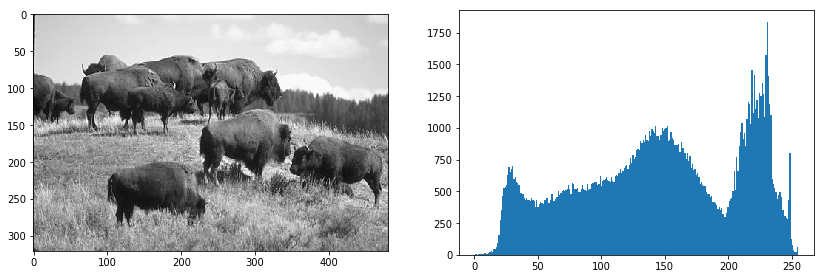

In [16]:
def plot_normal_dists(averages, variances, weights, xmin=0, xmax=255, ax=None):
    '''Plot Normal distributions with given parameters on the matplotlib axes 'ax'. 'xmin' and
       'xmax' sets the bounds of the x axis'''
    
    colors = ['#00ff00','#0000ff','#3effff','#b2df8a','#33a02c',
              '#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6',
              '#6a3d9a','#ffff99','#b15928']
    
    x = np.linspace(xmin, xmax)
    num_normals = len(averages)
    
    for i in range(num_normals):
        gauss = weights[i]*normal_1d(x, averages[i], variances[i])
        ax.plot(x, gauss, c=colors[i])
    
img = cv2.imread('gnu.jpg', 0)

plt.figure(figsize=[14, 4.5])
plt.subplot(1, 2, 1)
plt.imshow(img, 'gray')
plt.subplot(1, 2, 2)
_=plt.hist(img.ravel(), 255)

## Randomly initialize the averages, variances and weights

Averages:  [139.9474435  182.37328842 153.7046609 ]
Variances:  [267.2079148  161.5350501  375.46128476]
Weights:  [0.1908342  0.38890714 0.42025866]


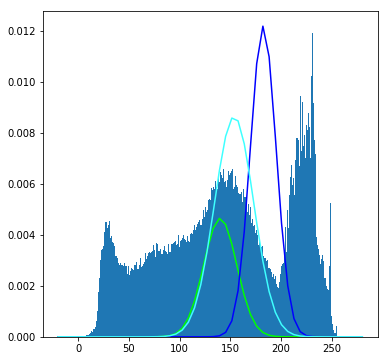

In [17]:
num_classes = 3

np.random.seed(0)
averages = np.random.rand(num_classes)*255
variances = (np.random.rand(num_classes)*30)**2
weights = np.random.rand(num_classes)
weights = weights/np.sum(weights)

print('Averages: ', averages)
print('Variances: ', variances)
print('Weights: ', weights)

plt.figure(figsize=[6, 6])
ax = plt.subplot(111)
ax.hist(img.ravel(), 255, density=True)
plot_normal_dists(averages, variances, weights, xmin=-20, xmax=280, ax=ax)

## Do one expectation-maximization step

Averages:  [111.17927713 207.66616826 120.0339326 ]
Variances:  [1014.01410723  525.78319053 4204.58815286]
Weights:  [0.21727073 0.30893521 0.47379407]


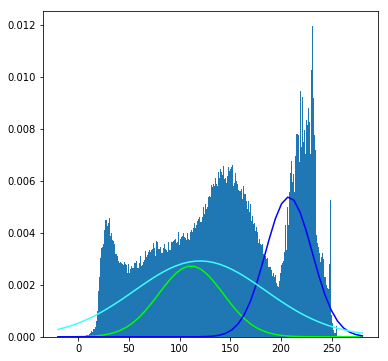

In [18]:
data = img.flatten()
gamma_matrix = expectation(data, averages, variances, weights)
averages, variances, weights = maximization(data, gamma_matrix)
    
print('Averages: ', averages)
print('Variances: ', variances)
print('Weights: ', weights)

plt.figure(figsize=[6, 6])
ax = plt.subplot(111)
ax.hist(img.ravel(), 255, density=True)
plot_normal_dists(averages, variances, weights, xmin=-20, xmax=280, ax=ax)    

## Do another expectation-maximization step

Averages:  [113.06247399 212.12782523 117.52550368]
Variances:  [1249.47157049  545.32687762 3612.41332172]
Weights:  [0.21079098 0.30229724 0.48691178]


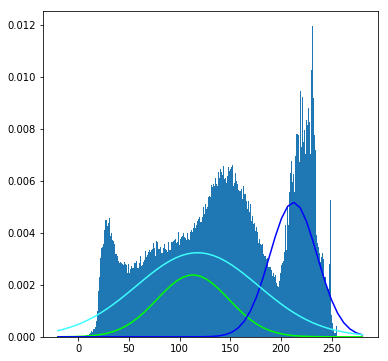

In [19]:
resp_matrix = expectation(data, averages, variances, weights)
averages, variances, weights = maximization(data, resp_matrix)
    
print('Averages: ', averages)
print('Variances: ', variances)
print('Weights: ', weights)

plt.figure(figsize=[6, 6])
ax = plt.subplot(111)
ax.hist(img.ravel(), 255, density=True)
plot_normal_dists(averages, variances, weights, xmin=-20, xmax=280, ax=ax)    

## Do many expectation-maximization steps, plotting intermediate Normal distributions

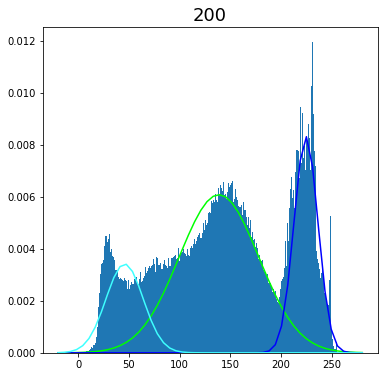

In [20]:
from IPython import display

fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(111)
for i in range(201):
    resp_matrix = expectation(data, averages, variances, weights)
    averages, variances, weights = maximization(data, resp_matrix)
    
    if i%5==0:
        ax.clear()
        ax.hist(img.ravel(), 255, density=True)
        plot_normal_dists(averages, variances, weights, xmin=-20, xmax=280, ax=ax) 
        ax.set_title(str(i), size=18)
        display.display(fig)
        display.clear_output(wait=True)

## Visualize results

Each gaussian represents the probability that a given intensity belongs to one of the classes. 

### Visualize the probability that each pixel belongs to each class

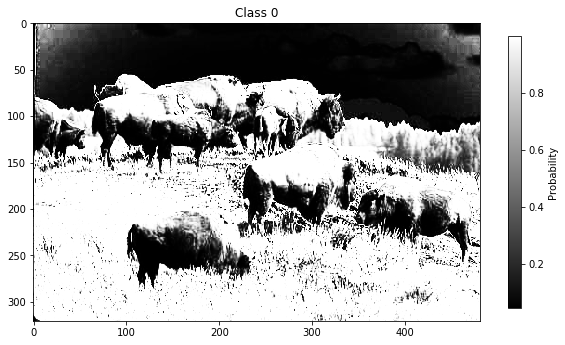

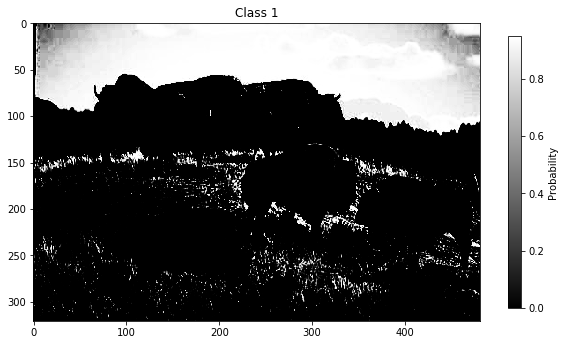

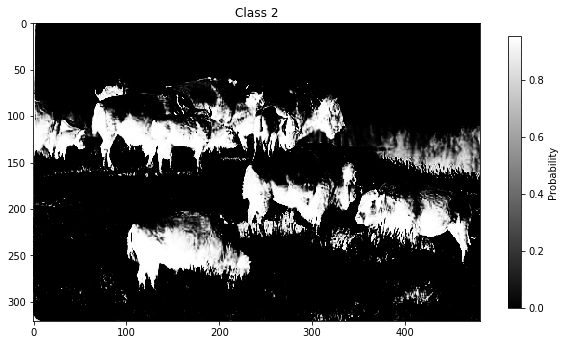

In [22]:
probs = np.zeros((num_classes, img.shape[0], img.shape[1]))
for class_idx in range(num_classes):
    probs[class_idx] = weights[class_idx]*normal_1d(img, averages[class_idx], variances[class_idx])
probs = probs/np.sum(probs,axis=0)

for class_idx in range(num_classes):
    plt.figure(figsize=[10, 10])
    plt.imshow(probs[class_idx], 'gray')
    cbar = plt.colorbar(shrink=0.5)
    cbar.set_label('Probability')
    plt.title('Class %d'%class_idx)



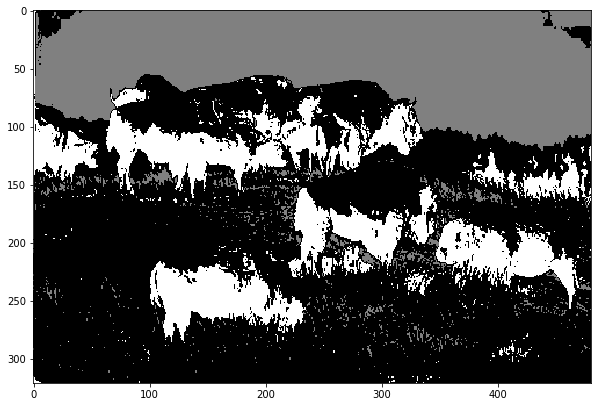

In [23]:
class_indices = np.argmax(probs, axis=0)

plt.figure(figsize=[10, 10])
plt.imshow(class_indices,'gray')

# Using scitkit-learn

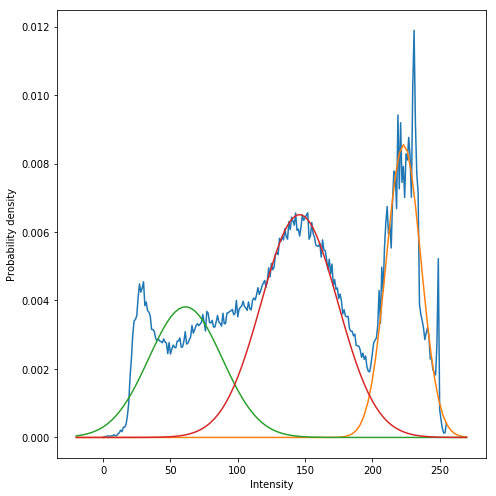

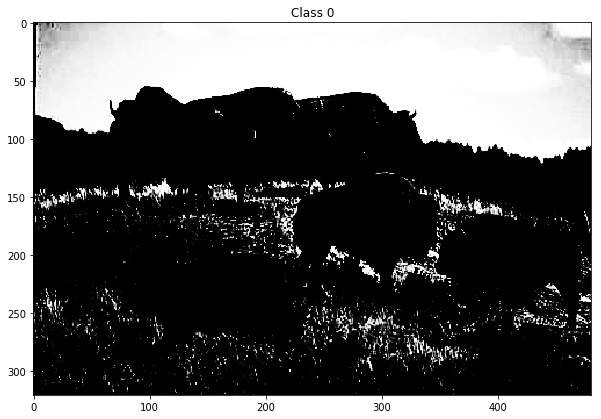

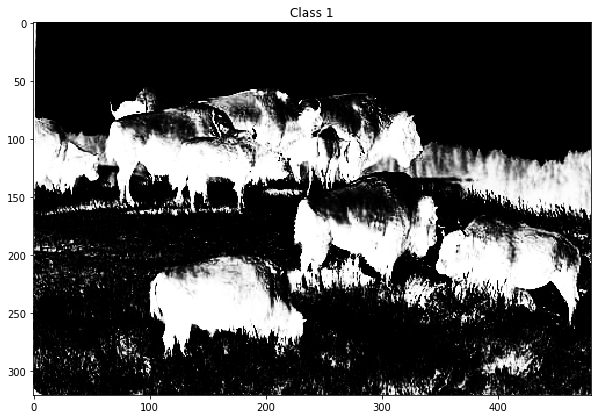

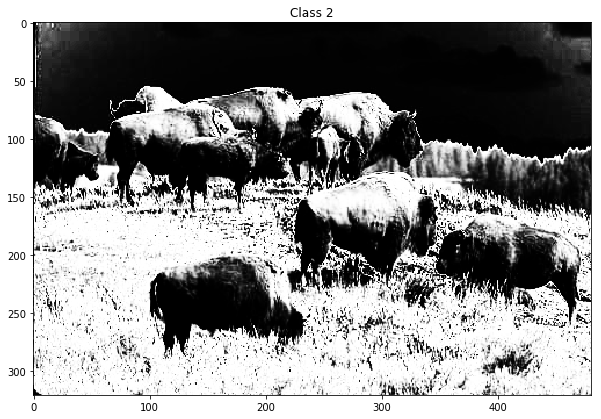

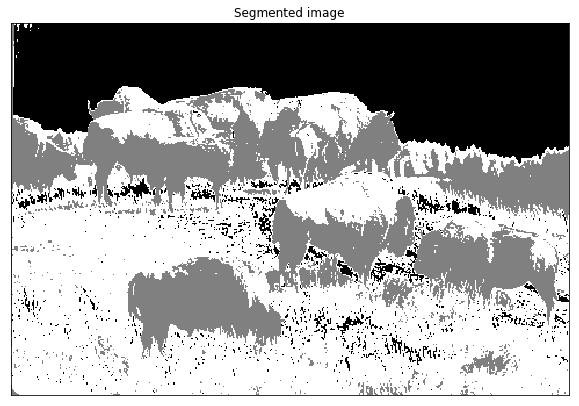

In [29]:
from sklearn.mixture import GaussianMixture

# Histogram normalized so that the area under the curve is equal to 1
# (a probability density function)
bins = range(257)
hist, _ = np.histogram(img, bins)
prob = hist/float(sum(hist)*(bins[1]-bins[0]))

# Create class instance and fit to data
gmm = GaussianMixture(n_components=3, covariance_type='spherical', n_init=10)
gmm.fit(img.reshape(-1, 1))

# Get information about the adjusted Normal distributions
averages = gmm.means_
variances = gmm.covariances_
weights = gmm.weights_

# Defining the probability functions
bins_model = np.linspace(-20, 270, 100)
p0 = weights[0]*normal_1d(bins_model, averages[0], variances[0])
p1 = weights[1]*normal_1d(bins_model, averages[1], variances[1])
p2 = weights[2]*normal_1d(bins_model, averages[2], variances[2])

# Probability of each pixel belonging to the different classes
probs = gmm.predict_proba(img.reshape(-1, 1))

class_indexes = np.argmax(probs, axis=1)
segmented_image = class_indexes.reshape(img.shape)

plt.figure(figsize=[7,7])
plt.plot(bins[:-1], prob)
plt.plot(bins_model, p0)
plt.plot(bins_model, p1)
plt.plot(bins_model, p2)
plt.xlabel('Intensity')
plt.ylabel('Probability density')
plt.tight_layout()

for i in range(3):
    plt.figure(figsize=[10,10])
    plt.imshow(probs[:,i].reshape(img.shape),'gray')
    plt.title('Class %d'%i)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

plt.figure(figsize=[10,10])
ax = plt.subplot(111)
plt.imshow(segmented_image,'gray')
plt.title('Segmented image')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [30]:
variances

array([165.827679  , 741.90267845, 807.19002752])